<a href="https://colab.research.google.com/github/marta-0/medical_mnist/blob/main/notebooks/t-SNE-visualisations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# t-SNE visualisations

In [ ]:
!pip install lapjv --quiet
!pip install rasterfairy-py3 --quiet

In [ ]:
import os
import random
import zipfile

from PIL import Image, ImageSequence

import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.python.keras.preprocessing import image

from lapjv import lapjv
from scipy.spatial.distance import cdist
import IPython

import rasterfairy
import io
from moviepy.editor import *

random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1753088/45929032 bytes (3.8%)4907008/45929032 bytes (10.7%)8208384/45929032 bytes (17.9%)11460608/45929032 bytes (25.0%)14745600/45929032 bytes (32.1%)17973248/45929032 bytes (39.1%)20815872/45929032 bytes (45.3%)24043520/45929032 bytes (52.3%)27312128/45929032 bytes (59.5%)30425088/45929032 bytes (66.2%)33898496/45929032 bytes (73.8%)36978688/45929032 bytes (80.5%)

In [ ]:
labels = ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']

In [ ]:
with zipfile.ZipFile('/content/models.zip','r') as zippedfile:
  zippedfile.extractall()

model_baseline = tf.keras.models.load_model('models/baseline')
model_gmp = tf.keras.models.load_model('models/gmp')
model_gmp_hflip_rot180 = tf.keras.models.load_model('models/gmp_hflip_rot180')
model_hflip = tf.keras.models.load_model('models/hflip')
model_rot180 = tf.keras.models.load_model('models/rotate180')
model_d01 = tf.keras.models.load_model('models/dropout_01')
model_d2_01 = tf.keras.models.load_model('models/dropout_2_01')
model_best = tf.keras.models.load_model('models/gmp+hflip+rot180+bn128')
model_best_var_sizes = tf.keras.models.load_model('models/best_various_sizes')
model_gmp_var_sizes = tf.keras.models.load_model('models/gmp_various_sizes')
model_gmp_hflip = tf.keras.models.load_model('models/gmp_hflip')
model_baseline_occ = tf.keras.models.load_model('models/baseline_occ')
model_best_occ = tf.keras.models.load_model('models/best_occ')
model_hflip_occ = tf.keras.models.load_model('models/hflip_occ')
model_d2_01_occ = tf.keras.models.load_model('models/dropout_2_01_occ')
model_gmp_occ = tf.keras.models.load_model('models/gmp_occ')

In [ ]:
with zipfile.ZipFile('data_24.zip','r') as zippedfile:
  zippedfile.extractall()
with zipfile.ZipFile('data_32_40.zip','r') as zippedfile:
  zippedfile.extractall()
with zipfile.ZipFile('data_48.zip','r') as zippedfile:
  zippedfile.extractall()
with zipfile.ZipFile('data_64.zip','r') as zippedfile:
  zippedfile.extractall()

X_test_24 = np.load('/content/data_24/X_test_24.npy')
y_test_24 = np.load('/content/data_24/y_test_24.npy')
X_test_32 = np.load('/content/data_32_40/X_test_32.npy')
y_test_32 = np.load('/content/data_32_40/y_test_32.npy')
X_test_40 = np.load('/content/data_32_40/X_test_40.npy')
y_test_40 = np.load('/content/data_32_40/y_test_40.npy')
X_test_48 = np.load('/content/data_48/X_test_48.npy')
y_test_48 = np.load('/content/data_48/y_test_48.npy')
X_test_64 = np.load('/content/data_64/X_test.npy')
y_test_64 = np.load('/content/data_64/y_test.npy')

Function calculating t-SNE 2D coordinates:

In [ ]:
def return_tsne(model, X_test, y_test, output_points, layer_name='global_max_pooling2d_1', low_res=False):
  activations = []
  
  if low_res:
    image = X_test

    for l in model.layers:
      if 'dense' in  l.name:
        break

      image = l(image)

      if layer_name in l.name:
        activations.append(image)

    activations = activations[0]

  else:
    intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    for i, img in enumerate(X_test):
      if i == output_points:
        break

      img = np.expand_dims(img, axis=0)
      activations.append(np.squeeze(intermediate_layer_model.predict(img)))

  tsne_results = TSNE(random_state=1).fit_transform(np.array(activations)[0:output_points,:])

  return tsne_results

Function showing only plot legend:

In [ ]:
def get_legend(legend_colors, legend_labels):
  plt.figure(figsize=(3.9,3.65))
  f = lambda m,c: plt.plot([], [], marker=m, color=c, ls="none")[0]
  handles = [f("s", legend_colors[i]) for i in range(len(legend_labels))]
  legend = plt.legend(handles, legend_labels, loc=3, framealpha=1, frameon=True, fontsize=20, markerscale=3)

  plt.gca().set_axis_off()
  plt.show()

## Mosaics

In [ ]:
def tsne_mosaic(tsne_results, X_test, y_test, output_rows, out_res=64, show_img=False, gray_scale=False, color_scale=False):
  output_num_img = output_rows * output_rows
  
  tsne_results -= tsne_results.min(axis=0)
  tsne_results /= tsne_results.max(axis=0)


  grid = np.dstack(np.meshgrid(np.linspace(0, 1, output_rows), np.linspace(0, 1, output_rows))).reshape(-1, 2)
  cost_matrix = cdist(grid, tsne_results, "sqeuclidean").astype(np.float32)
  cost_matrix = cost_matrix * (100000 / cost_matrix.max())
  row_asses, col_asses, _ = lapjv(cost_matrix)
  grid_jv = grid[col_asses]
  out = np.ones((output_rows*out_res, output_rows*out_res, 3))


  i = 0
  for pos, img in zip(grid_jv, X_test[0:output_num_img]):
      h_range = int(round(pos[0] * (output_rows - 1) * out_res))
      w_range = int(round(pos[1] * (output_rows - 1) * out_res))

      if gray_scale:
        _img = image.img_to_array(img)
        _img[:,:] = np.argmax(y_test[i]) * 50
        i = i + 1
        scale = '_gray'
        out = out.astype(np.uint8)

      elif color_scale:
        colors = [sns.color_palette('Set2', 6)[5],
                  sns.color_palette('Set2', 6)[3],
                  sns.color_palette('Set2', 6)[2],
                  sns.color_palette('Set2', 6)[1],
                  sns.color_palette('Set2', 6)[4],
                  sns.color_palette('Set2', 6)[0]]

        _img = np.full((out_res,out_res,3),colors[np.argmax(y_test[i])])
        i = i + 1
        scale = '_color'
      
      else:
        scale = ''
        _img = image.img_to_array(img)

      out[h_range:h_range + out_res, w_range:w_range + out_res] = _img


  filename = 'tsne_mosaic_' + str(output_rows) + scale + '.jpg'
  out = image.array_to_img(out)
  out.save(filename)

  if show_img:
    IPython.display.display(IPython.display.Image(data=filename, width=550, height=550))

20 x 20 images:

In [ ]:
tsne_results_400 = return_tsne(model_best, X_test_64, y_test_64, 20*20)
tsne_mosaic(tsne_results_400, X_test_64, y_test_64, 20, show_img=True)

30 x 30 images:

In [ ]:
tsne_results_900 = return_tsne(model_best, X_test_64, y_test_64, 30*30)
tsne_mosaic(tsne_results_900, X_test_64, y_test_64, 30, show_img=True)

In [ ]:
tsne_mosaic(tsne_results_900, X_test_64, y_test_64, 30, show_img=True, color_scale=True)

40 x 40 images:

In [ ]:
tsne_results_1600 = return_tsne(model_best, X_test_64, y_test_64, 40*40)
tsne_mosaic(tsne_results_1600, X_test_64, y_test_64, 40, show_img=True)

132 x 132 images (test set contains 17687 images; square root is 132 rounding down - so that there are no empty spaces):

In [ ]:
tsne_results_17424 = return_tsne(model_best, X_test_64, y_test_64, 132*132)
tsne_mosaic(tsne_results_17424, X_test_64, y_test_64, 132, show_img=True)

In [ ]:
tsne_mosaic(tsne_results_17424, X_test_64, y_test_64, 132, show_img=True, color_scale=True)

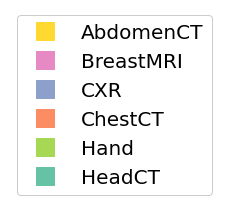

In [ ]:
new_legend_colors = [sns.color_palette('Set2', 6)[5],
                     sns.color_palette('Set2', 6)[3],
                     sns.color_palette('Set2', 6)[2],
                     sns.color_palette('Set2', 6)[1],
                     sns.color_palette('Set2', 6)[4],
                     sns.color_palette('Set2', 6)[0]]

get_legend(new_legend_colors, labels)

In [ ]:
tsne_mosaic(tsne_results_17424, X_test_64, y_test_64, 132, show_img=True, gray_scale=True)

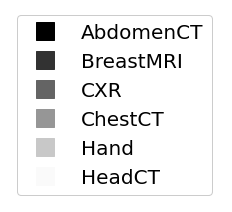

In [ ]:
get_legend([(i*50/255.0, i*50/255.0, i*50/255.0, 1.0) for i in range(len(labels))], labels)

Function blending two mosaics:

In [ ]:
def blend_mosaics(img1, img2, filename, alpha=0.3):
  res = Image.blend(img1, img2, alpha)

  res.save(filename)
  IPython.display.display(IPython.display.Image(data=filename, width=550, height=550))

In [ ]:
blend_mosaics(Image.open('/content/tsne_mosaic_132.jpg'), Image.open('/content/tsne_mosaic_132_color.jpg'), 'tsne_mosaics_added_132.jpg')

In [ ]:
blend_mosaics(Image.open('/content/tsne_mosaic_30.jpg'), Image.open('/content/tsne_mosaic_30_color.jpg'), 'tsne_mosaics_added_30.jpg')

## Scatter plots

In [ ]:
def tsne_scatter(tsne_results, X_test, y_test, title, loc=4, as_dots=True):
  tsne_results -= tsne_results.min(axis=0)
  tsne_results /= tsne_results.max(axis=0)

  y_labels = list(map(lambda x: labels[x], np.argmax(y_test, axis=1)))


  if as_dots:
    df = pd.DataFrame(y_labels, columns=['label'])
    df['tsne-2d-one'] = tsne_results[:,0]
    df['tsne-2d-two'] = tsne_results[:,1]

    plt.figure(figsize=(16,10))
    ax = sns.scatterplot(x='tsne-2d-one', y='tsne-2d-two', hue='label', palette=sns.color_palette('Set2', 6), data=df, legend='full', alpha=0.3)
    plt.legend()
    handles, legend_labels = ax.get_legend_handles_labels()
    legend_labels, handles = zip(*sorted(zip(legend_labels, handles), key=lambda t: t[0]))
    ax.legend(handles=handles, labels=legend_labels, loc=loc, fontsize=15)


  else:
    fig, ax = plt.subplots(figsize=(20,15))
    artists = []
    size = X_test.shape[1]
    index = 0

    for xy, i in zip(tsne_results, np.squeeze(X_test)):
      
      img_ = np.dstack((i, i, i))

      color_index = np.argmax(y_test[index])
      if np.argmax(y_test[index]) == 0:
        color_index = 5
      elif np.argmax(y_test[index]) == 1:
        color_index = 3
      elif np.argmax(y_test[index]) == 3:
        color_index = 1 
      elif np.argmax(y_test[index]) == 5:
        color_index = 0

      for w in range(size):
        for h in range(size):
          if (h < 1) or (h > size-3):
            img_[h:h+2,:,0] = sns.color_palette('Set2',6)[color_index][0]
            img_[h:h+2,:,1] = sns.color_palette('Set2',6)[color_index][1]
            img_[h:h+2,:,2] = sns.color_palette('Set2',6)[color_index][2]

          if (w < 1) or (w > size-3):
            img_[:,w:w+2,0] = sns.color_palette('Set2',6)[color_index][0]
            img_[:,w:w+2,1] = sns.color_palette('Set2',6)[color_index][1]
            img_[:,w:w+2,2] = sns.color_palette('Set2',6)[color_index][2]

      x0, y0 = xy
      img = OffsetImage(img_)
      ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
      artists.append(ax.add_artist(ab))
      index = index + 1

    ax.update_datalim(tsne_results)
    ax.autoscale()


  plt.title(title, fontsize=25)
  plt.xticks(fontsize=20)
  plt.yticks(fontsize=20)
  plt.xlabel('tsne-2d-one', fontsize=20)
  plt.ylabel('tsne-2d-two', fontsize=20)
  plt.show()

In [ ]:
tsne_results_best = return_tsne(model_best, X_test_64, y_test_64, X_test_64.shape[0])
tsne_scatter(tsne_results_best, X_test_64, y_test_64, 'Best model', loc=2)

In [ ]:
tsne_results_gmp = return_tsne(model_gmp, X_test_64, y_test_64, X_test_64.shape[0])
tsne_scatter(tsne_results_gmp, X_test_64, y_test_64, 'Global Max Pooling', loc=2)

In [ ]:
tsne_results_gmp_hflip = return_tsne(model_gmp_hflip, X_test_64, y_test_64, X_test_64.shape[0], layer_name='global_max_pooling2d_2')
tsne_scatter(tsne_results_gmp_hflip, X_test_64, y_test_64, 'Global Max Pooling + Horizontal flip', loc=2)

In [ ]:
tsne_results_gmp_hflip_rot180 = return_tsne(model_gmp_hflip_rot180, X_test_64, y_test_64, X_test_64.shape[0])
tsne_scatter(tsne_results_gmp_hflip_rot180, X_test_64, y_test_64, 'Global Max Pooling + Horizontal flip + Rotation <= 180°', loc=2)

In [ ]:
tsne_results_var_sizes = return_tsne(model_best_var_sizes, X_test_64, y_test_64, X_test_64.shape[0], layer_name='global_max_pooling2d_2')
tsne_scatter(tsne_results_var_sizes, X_test_64, y_test_64, 'Best model - trained on different size images generator', loc=2)

In [ ]:
tsne_results_gmp_var_sizes = return_tsne(model_gmp_var_sizes, X_test_64, y_test_64, X_test_64.shape[0])
tsne_scatter(tsne_results_gmp_var_sizes, X_test_64, y_test_64, 'Global Max Pooling - trained on different size images generator', loc=2)

## Scatter plots - smaller input images

In [ ]:
tsne_results_best_24 = return_tsne(model_best, X_test_24, y_test_24, X_test_24.shape[0], low_res=True)
tsne_scatter(tsne_results_best_24, X_test_24, y_test_24, 'Best model - image size 24 x 24 px')

In [ ]:
tsne_results_best_32 = return_tsne(model_best, X_test_32, y_test_32, X_test_32.shape[0], low_res=True)
tsne_scatter(tsne_results_best_32, X_test_32, y_test_32, 'Best model - image size 32 x 32 px')

In [ ]:
tsne_results_best_40 = return_tsne(model_best, X_test_40, y_test_40, X_test_40.shape[0], low_res=True)
tsne_scatter(tsne_results_best_40, X_test_40, y_test_40, 'Best model - image size 40 x 40 px')

In [ ]:
tsne_results_best_48 = return_tsne(model_best, X_test_48, y_test_48, X_test_48.shape[0], low_res=True)
tsne_scatter(tsne_results_best_48, X_test_48, y_test_48, 'Best model - image size 48 x 48 px')

In [ ]:
tsne_results_best_var_24 = return_tsne(model_best_var_sizes, X_test_24, y_test_24, X_test_24.shape[0], layer_name='global_max_pooling2d_2', low_res=True)
tsne_scatter(tsne_results_best_var_24, X_test_24, y_test_24, 'Best model - trained on different size images generator - image size 24 x 24 px')

In [ ]:
tsne_results_best_var_32 = return_tsne(model_best_var_sizes, X_test_32, y_test_32, X_test_32.shape[0], layer_name='global_max_pooling2d_2', low_res=True)
tsne_scatter(tsne_results_best_var_32, X_test_32, y_test_32, 'Best model - trained on different size images generator - image size 32 x 32 px')

In [ ]:
tsne_results_best_var_40 = return_tsne(model_best_var_sizes, X_test_40, y_test_40, X_test_40.shape[0], layer_name='global_max_pooling2d_2', low_res=True)
tsne_scatter(tsne_results_best_var_40, X_test_40, y_test_40, 'Best model - trained on different size images generator - image size 40 x 40 px')

In [ ]:
tsne_results_best_var_48 = return_tsne(model_best_var_sizes, X_test_48, y_test_48, X_test_48.shape[0], layer_name='global_max_pooling2d_2', low_res=True)
tsne_scatter(tsne_results_best_var_48, X_test_48, y_test_48, 'Best model - trained on different size images generator- image size 48 x 48 px')

## Scatter plots with images

In [ ]:
tsne_scatter(tsne_results_best, X_test_64, y_test_64, 'Best model', as_dots=False)

In [ ]:
tsne_scatter(tsne_results_best_24, X_test_24, y_test_24, 'Best model - image size 24 x 24 px', as_dots=False)

In [ ]:
tsne_scatter(tsne_results_gmp, X_test_64, y_test_64, 'Global Max Pooling', as_dots=False)

In [ ]:
tsne_results_gmp_24 = return_tsne(model_gmp, X_test_24, y_test_24, X_test_24.shape[0], low_res=True)
tsne_scatter(tsne_results_gmp_24, X_test_24, y_test_24, 'Global Max Pooling - image size 24 x 24 px', as_dots=False)

## RasterFairy

In [ ]:
def raster_fairy(tsne_results, X_test, y_test, title, rect=True, circle=False, as_img=False, target_grid=None, return_params=False):
  if rect:
    grid_xy, (width, height) = rasterfairy.transformPointCloud2D(tsne_results)

  elif circle:
    radius, adjustmentFactor, count = rasterfairy.getBestCircularMatch(X_test.shape[0])
    print('The smallest circle that can hold', X_test.shape[0], 'has a radius of', radius, 'and will fit', count, 'points')

    arrangement = rasterfairy.getCircularArrangement(radius, adjustmentFactor)
    rasterMask = rasterfairy.arrangementToRasterMask(arrangement)

    grid_xy, (width, height) = rasterfairy.transformPointCloud2D(tsne_results, target=rasterMask, autoAdjustCount = False)

  else:
      rasterMask = rasterfairy.getRasterMaskFromImage(target_grid)
      print(rasterMask['count'], 'black pixels in map')

      grid_xy, (width, height) = rasterfairy.transformPointCloud2D(tsne_results, target=rasterMask, autoAdjustCount=True)

      dim = max(width, height)
      grid_xy[:,0] += 0.5*(dim-width)
      grid_xy[:,1] += 0.5*(dim-height)


  if as_img:
    fig, ax = plt.subplots(figsize=(20,15))
    artists = []
    size = X_test.shape[1]
    index = 0

    for xy, i in zip(grid_xy, np.squeeze(X_test)):
      img_ = np.dstack((i, i, i))

      color_index = np.argmax(y_test[index])
      if np.argmax(y_test[index]) == 0:
        color_index = 5
      elif np.argmax(y_test[index]) == 1:
        color_index = 3
      elif np.argmax(y_test[index]) == 3:
        color_index = 1 
      elif np.argmax(y_test[index]) == 5:
        color_index = 0

      for w in range(size):
        for h in range(size):
          if (h < 1) or (h > size-3):
            img_[h:h+2,:,0] = sns.color_palette('Set2',6)[color_index][0]
            img_[h:h+2,:,1] = sns.color_palette('Set2',6)[color_index][1]
            img_[h:h+2,:,2] = sns.color_palette('Set2',6)[color_index][2]

          if (w < 1) or (w > size-3):
            img_[:,w:w+2,0] = sns.color_palette('Set2',6)[color_index][0]
            img_[:,w:w+2,1] = sns.color_palette('Set2',6)[color_index][1]
            img_[:,w:w+2,2] = sns.color_palette('Set2',6)[color_index][2]
        
      x0, y0 = xy
      img = OffsetImage(img_)
      ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
      artists.append(ax.add_artist(ab))
      index = index + 1

    ax.update_datalim(grid_xy)
    ax.autoscale()


  else:
    y_labels = list(map(lambda x: labels[x], np.argmax(y_test, axis=1)))
    df = pd.DataFrame(y_labels, columns=['label'])
    df['grid-xy-one'] = grid_xy[:,0]
    df['grid-xy-two'] = grid_xy[:,1]

    fig = plt.figure(figsize=(10,10))
    ax = sns.scatterplot(x='grid-xy-one', y='grid-xy-two', hue='label', palette=sns.color_palette('Set2', 6), data=df, legend=False)


  ax.spines['top'].set_visible(False)
  ax.spines['right'].set_visible(False)
  ax.spines['bottom'].set_visible(False)
  ax.spines['left'].set_visible(False)
  ax.axes.get_xaxis().set_visible(False)
  ax.axes.get_yaxis().set_visible(False)
  ax.autoscale_view(True,True,True)
  ax.invert_yaxis()
  plt.title(title, fontsize=20)
  plt.show()

  if return_params:
    return grid_xy, width, height

In [ ]:
tsne_results_1_20th = return_tsne(model_best, X_test_64[::20], y_test_64[::20], X_test_64[::20].shape[0])
grid_xy_rect, width_rect, height_rect = raster_fairy(tsne_results_1_20th, X_test_64[::20], y_test_64[::20], 'Best model', return_params=True)

In [ ]:
tsne_results_1_20th_32 = return_tsne(model_best, X_test_32[::20], y_test_32[::20], X_test_32[::20].shape[0], low_res=True)
raster_fairy(tsne_results_1_20th_32, X_test_32[::20], y_test_32[::20], 'Best model - image size 32 x 32 px')

Plotting with 32 x 32 px images, so they do not overlap on the plot:

In [ ]:
raster_fairy(tsne_results_1_20th_32, X_test_32[::20], y_test_32[::20], 'Best model - image size 32 x 32 px', as_img=True)

In [ ]:
grid_xy_circle, width_circle, height_circle = raster_fairy(tsne_results_1_20th, X_test_64[::20], y_test_64[::20], 'Best model', rect=False, circle=True, return_params=True)

In [ ]:
raster_fairy(tsne_results_1_20th_32, X_test_32[::20], y_test_32[::20], 'Best model - image size 32 x 32 px', rect=False, circle=True, as_img=True)

Using custom binary mask:

In [ ]:
target_tree = Image.open('/content/christmas_tree.jpg')
target_tree

In [ ]:
raster_fairy(tsne_results_1_20th, X_test_64[::20], y_test_64[::20], 'Best model', rect=False, circle=False, target_grid=target_tree)

In [ ]:
raster_fairy(tsne_results_1_20th_32, X_test_32[::20], y_test_32[::20], 'Best model - image size 32 x 32 px', rect=False, circle=False, as_img=True, target_grid=target_tree)

In [ ]:
target_hand = Image.open('/content/hand_mask.jpeg')
target_hand

In [ ]:
grid_xy_hand, width_hand, height_hand = raster_fairy(tsne_results_1_20th, X_test_64[::20], y_test_64[::20], 'Best model', rect=False, circle=False, target_grid=target_hand, return_params=True)

In [ ]:
raster_fairy(tsne_results_1_20th_32, X_test_32[::20], y_test_32[::20], 'Best model - image size 32 x 32 px', rect=False, circle=False, as_img=True, target_grid=target_hand)

## RasterFairy - animation

Images sequence may be saved as gif directly by the function (as_gif=True) or the images may be saved as jpgs and processed later externally (eg. using ffmpeg).

In [ ]:
def raster_fairy_gif(tsne_results, grid_xy, width, height, X_test, y_test, name, as_gif=True):
  images = []
  pointCount = len(X_test)

  px_from = grid_xy[:,0] - min(grid_xy[:,0])
  py_from = grid_xy[:,1] - min(grid_xy[:,1])
  px_from /= max(px_from)
  py_from /= max(py_from)

  px_to = tsne_results[:,0] - min(tsne_results[:,0])
  py_to = tsne_results[:,1] - min(tsne_results[:,1])
  px_to /= max(px_to)
  py_to /= max(py_to)

  if (width > height):
      py_to = py_to * float(height) / float(width) + 0.5 * (1.0 - float(height) / float(width))
  else:
      px_to = px_to * float(width) / float(height) + 0.5 * (1.0 - float(width) / float(height))

  y_labels = list(map(lambda x: labels[x], np.argmax(y_test, axis=1)))

  steps = 50
  for i in range(steps*2):
      dx = []
      dy = []
      t = 1.0- abs(1.0 * i / (steps-1) - 1.0)

      for j in range(pointCount):
          dx.append((1.0-t)*px_from[j] + t*px_to[j])
          dy.append((1.0-t)*py_from[j] + t*py_to[j])
      
      df = pd.DataFrame(y_labels, columns=['label'])
      df['dx'] = dx
      df['dy'] = dy
      fig2 = plt.figure(figsize=(10,10))
      ax = sns.scatterplot(x='dx', y='dy', hue='label', palette=sns.color_palette('Set2', 6), data=df, legend=False)
      ax.spines['top'].set_visible(False)
      ax.spines['right'].set_visible(False)
      ax.spines['bottom'].set_visible(False)
      ax.spines['left'].set_visible(False)
      ax.axes.get_xaxis().set_visible(False)
      ax.axes.get_yaxis().set_visible(False)
      ax.axes.set_xlim([-0.01, 1.01])
      ax.axes.set_ylim([-0.01, 1.01])
      ax.invert_yaxis()
      IPython.display.clear_output(wait=True)
      
      buf = io.BytesIO()
      plt.savefig(buf, format='jpg')
      buf.seek(0)

      if as_gif:
        images.append(np.array(Image.open(buf)))
      else:
        (Image.open(buf)).save(name + '/frame%04d.jpg' % i)
      
  if as_gif:
    clip = ImageSequenceClip(images,fps=25)
    clip.write_gif(name + '.gif')

In [ ]:
raster_fairy_gif(tsne_results_1_20th, grid_xy_rect, width_rect, height_rect, X_test_64[::20], y_test_64[::20], 'rectangle')

In [ ]:
with open('/content/rectangle.gif','rb') as f:
  IPython.display.display(IPython.display.Image(data=f.read(), format='png'))

In [ ]:
raster_fairy_gif(tsne_results_1_20th, grid_xy_circle, width_circle, height_circle, X_test_64[::20], y_test_64[::20], 'circle')

In [ ]:
with open('/content/circle.gif','rb') as f:
  IPython.display.display(IPython.display.Image(data=f.read(), format='png'))

In [ ]:
raster_fairy_gif(tsne_results_1_20th, grid_xy_hand, width_hand, height_hand, X_test_64[::20], y_test_64[::20], 'hand')

In [ ]:
with open('/content/hand.gif','rb') as f:
  IPython.display.display(IPython.display.Image(data=f.read(), format='png'))